In [1]:
import os
data_dir = 'data/jena_climate_2009_2016.csv'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
from matplotlib import pyplot as plt
temp = float_data[:, 1] 
#<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

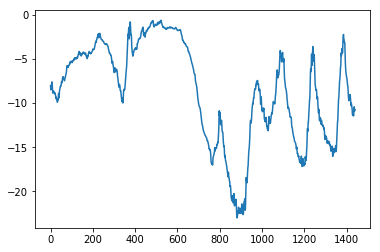

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
            #生成闭区间[low,high]上离散均匀分布的整数值 (min_index + lookback和max_index間，
            """size:Output shape. If the given shape is, e.g., (m, n, k),
            then m * n * k samples are drawn. Default is None,
            in which case a single value is returned."""
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            """
            arange([start,] stop[, step,], dtype=None)
            根据start与stop指定的范围以及step设定的步长，生成一个 ndarray。
              >>> np.arange(3)
                array([0, 1, 2])
                >>> np.arange(3.0)
                array([ 0.,  1.,  2.])
                >>> np.arange(3,7)
                array([3, 4, 5, 6])
                >>> np.arange(3,7,2)
                array([3, 5])
            """
            
            i += len(rows)
                
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [9]:
def formulate(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
            #生成闭区间[low,high]上离散均匀分布的整数值 (min_index + lookback和max_index間，
            """size:Output shape. If the given shape is, e.g., (m, n, k),
            then m * n * k samples are drawn. Default is None,
            in which case a single value is returned."""
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            """
            arange([start,] stop[, step,], dtype=None)
            根据start与stop指定的范围以及step设定的步长，生成一个 ndarray。
              >>> np.arange(3)
                array([0, 1, 2])
                >>> np.arange(3.0)
                array([ 0.,  1.,  2.])
                >>> np.arange(3,7)
                array([3, 4, 5, 6])
                >>> np.arange(3,7,2)
                array([3, 5])
            """
            
            i += len(rows)
                
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        return samples, targets

In [10]:
print(float_data.shape)
print(float_data.shape[-1])


(420551, 14)
14


In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [12]:
test_1 = formulate(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

In [13]:
test_1

(array([[[ 2.26682283e+00,  2.85400820e-02, -1.45903961e-01, ...,
           1.19023789e+00,  1.16296489e+00,  4.65090223e-01],
         [ 2.24441832e+00, -2.00337722e-02, -1.92814343e-01, ...,
           5.00432140e-01,  3.90655771e-01,  5.30900031e-01],
         [ 2.22790973e+00, -1.37514722e-01, -3.06739558e-01, ...,
          -1.95881210e-01, -4.67465474e-01,  4.54699201e-01],
         ...,
         [ 1.50742772e+00, -7.65149980e-02, -1.91697430e-01, ...,
          -1.30805196e-01,  4.67886683e-01,  1.59771165e+00],
         [ 1.51804039e+00,  3.68834266e-03, -1.13513459e-01, ...,
          -1.69850804e-01,  6.45696978e-02,  8.72649207e-01],
         [ 1.49209832e+00,  1.09873047e-01, -6.28972733e-03, ...,
          -6.38398105e-01, -2.61516375e-01,  1.64043030e+00]],
 
        [[ 3.90739577e-01,  6.55481689e-01,  6.19182039e-01, ...,
          -4.30154860e-01,  2.19031522e-01, -1.78895341e+00],
         [ 4.09606536e-01,  6.50963191e-01,  6.12480556e-01, ...,
          -7.87443847

In [14]:
test_1.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [15]:
#全部40萬，0~20萬做training，20~30萬做validate，30~40多萬做testing
train_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [16]:
dir(test_gen)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

In [17]:
abc= next(test_gen)

In [18]:
iou = next(test_gen)

In [19]:
abcd = np.asarray(abc)

ValueError: could not broadcast input array from shape (128,240,14) into shape (128)

In [20]:
#How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback)
#How many steps to draw from test_gen in order to see the entire test set 
test_steps = (len(float_data) - 300001 - lookback)

A common-sense, non-machine-learning baseline

In [21]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.28969941979609765


In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae',metrics=['mae'])
#沒有下metrics，所以後來testing完叫不出MAE
# You do so using the fit_generator method, 
#the equivalent of fit for data generators like this one. It expects as its first
#argument a Python generator
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
validation_data=val_gen,
validation_steps=val_steps)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/10
500/500 [==============================] - 911s 2s/step - loss: 1.0050 - val_loss: 0.3410
Epoch 2/10
500/500 [==============================] - 917s 2s/step - loss: 0.3483 - val_loss: 0.3431
Epoch 3/10
500/500 [==============================] - 907s 2s/step - loss: 0.2810 - val_loss: 0.2954
Epoch 4/10
500/500 [==============================] - 914s 2s/step - loss: 0.2630 - val_loss: 0.3123
Epoch 5/10
500/500 [==============================] - 908s 2s/step - loss: 0.2501 - val_loss: 0.3155
Epoch 6/10
500/500 [==============================] - 916s 2s/step - loss: 0.2440 - val_loss: 0.3094
Epoch 7/10
500/500 [==============================] - 909s 2s/step - loss: 0.2364 - val_loss: 0.3255
Epoch 8/10
500/500 [==============================] - 915s 2s/step - loss: 0.2321 - val_loss: 0.3232
Epoch 9/10
500/500 [==============================] - 920s 2s/step - loss: 0.2274 - val_loss: 0.3339
Epoch 10/10
500/500 [==============================] - 911s 2s/step - loss: 0.2237 - val_lo

Listing 6.37 Training and evaluating a densely connected model

Listing 6.38 Plotting results

In [23]:
history.history

{'loss': [1.0049655367136001,
  0.3482664279341698,
  0.2810264687240124,
  0.263002507597208,
  0.2501384421288967,
  0.24400233647227287,
  0.23635538518428803,
  0.2321345220208168,
  0.22744589719176292,
  0.22372528111934661],
 'val_loss': [0.34098632405313173,
  0.3431304930648212,
  0.2954375526995629,
  0.312288147872313,
  0.3155093983011231,
  0.30942791960550264,
  0.32551589782106605,
  0.3231907552904091,
  0.3338668007926693,
  0.3232724011252946]}

In [24]:
mae_history = history.history['val_mean_absolute_error']

KeyError: 'val_mean_absolute_error'

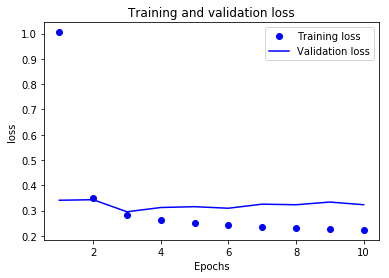

In [25]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()